# LAB | Audio Classification CNN

## Introduction
This notebook guides you through audio classification using a CNN model on the Kaggle audio dataset. You will:
- Load and explore the dataset
- Apply various preprocessing methods (MFCC, Mel spectrogram, Chromagram)
- Build and train a CNN classifier on these features
- Experiment with preprocessing parameters to improve results

## Step 1: Setup & Dataset Loading

In [1]:
# !pip install librosa

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("warcoder/cats-vs-dogs-vs-birds-audio-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cats-vs-dogs-vs-birds-audio-classification' dataset.
Path to dataset files: /kaggle/input/cats-vs-dogs-vs-birds-audio-classification


In [3]:
files_in_dir = os.listdir(path)
print(files_in_dir)

['Animals']


In [4]:
#TODO: create a dataframe

# Go inside the "Animals" folder
animals_path = os.path.join(path, "Animals")

data = []

for label in os.listdir(animals_path):        # loop subfolders (cats, dogs, birds)
    folder = os.path.join(animals_path, label)
    if os.path.isdir(folder):
        for file in os.listdir(folder):       # loop files in each folder
            if file.endswith(".wav"):         # only take .wav files
                filepath = os.path.join(folder, file)
                data.append([filepath, label]) # store file + label

df = pd.DataFrame(data, columns=['file_path', 'label'])


In [5]:
df

,file_path,label
0,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,dog
1,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,dog
2,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,dog
3,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,dog
4,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,dog
...,...,...
605,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,cat
606,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,cat
607,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,cat
608,/kaggle/input/cats-vs-dogs-vs-birds-audio-clas...,cat


## Step 2: Audio Preprocessing Functions

Define functions for feature extraction you will experiment with:

- MFCC
- Spectrogram
- Chromogram

In [6]:
##TODO: Your_Code_Here

# MFCC Spectrum = Mel Frequency Cepstral Coefficients

def extract_mfcc(file_path, n_mfcc=13, max_len=100):
    """
    Extract MFCC features from audio file
    MFCC = Mel Frequency Cepstral Coefficients - represents the short-term power spectrum of sound
    """
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        # # Pad or truncate to fixed length (so all have same size for CNN)
        # if mfccs.shape[1] < max_len:
        #     pad_width = max_len - mfccs.shape[1]
        #     mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        # else:
        #     mfccs = mfccs[:, :max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Spectrogram:

def extract_mel_spectrogram(file_path, n_mels=128, max_len=100):
    """
    Extract Mel Spectrogram - shows how frequencies change over time
    """
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Create Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

        # # Fixed length
        # if mel_spec_db.shape[1] < max_len:
        #     pad_width = max_len - mel_spec_db.shape[1]
        #     mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        # else:
        #     mel_spec_db = mel_spec_db[:, :max_len]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Chromagram = musical pitch content

def extract_chromagram(file_path, max_len=100):
    """
    Extract Chromagram - represents musical pitch content
    """
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Create Chromagram
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)

        # # Fixed length
        # if chroma.shape[1] < max_len:
        #     pad_width = max_len - chroma.shape[1]
        #     chroma = np.pad(chroma, pad_width=((0, 0), (0, pad_width)), mode='constant')
        # else:
        #     chroma = chroma[:, :max_len]

        return chroma
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

## Step 3: Visualize Audio Features



Visualize extracted features for a sample audio file:

In [7]:
def plot_mel(spectrogram, sr=16000):
    """Plot Mel spectrogram"""
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.show()

def plot_mfcc(mfccs, sr=16000):
    """Plot MFCC coefficients"""
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC coefficients')
    plt.show()

def plot_chroma(chroma, sr=16000):
    """Plot Chromagram"""
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram')
    plt.show()


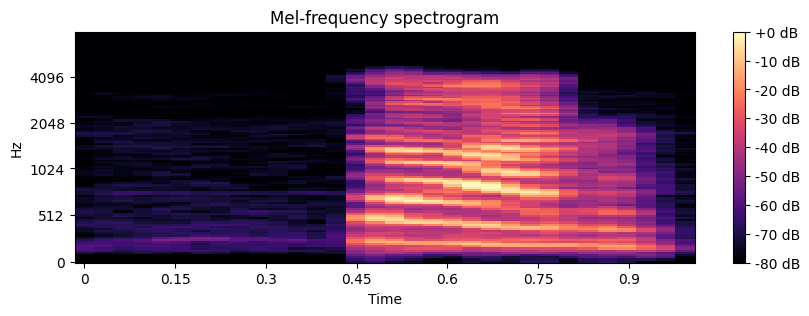

Mel Spectrogram shape: (128, 32)


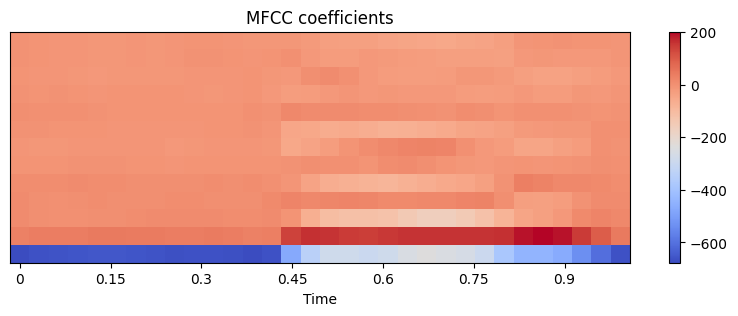

MFCC shape: (13, 32)


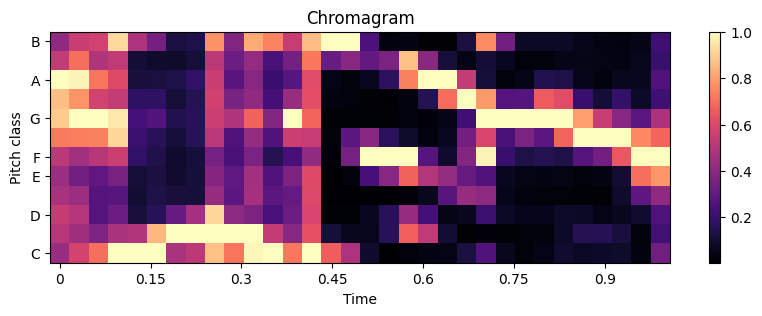

Chromagram shape: (12, 32)


In [8]:
# Test with one file
file_path_test = df['file_path'].iloc[0]
sr = 16000

# Mel Spectrogram
mel_db = extract_mel_spectrogram(file_path_test)
plot_mel(mel_db, sr)
print(f"Mel Spectrogram shape: {mel_db.shape}")

# MFCC
mfcc = extract_mfcc(file_path_test)
plot_mfcc(mfcc, sr)
print(f"MFCC shape: {mfcc.shape}")

# # Chromagram
chroma = extract_chromagram(file_path_test)
plot_chroma(chroma, sr)
print(f"Chromagram shape: {chroma.shape}")

In [9]:
# Shape of different ones:

print(f"Mel Spectrogram shape: {mel_db.shape}")

# MFCC

print(f"MFCC shape: {mfcc.shape}")

# # Chromagram
print(f"Chromagram shape: {chroma.shape}")

Mel Spectrogram shape: (128, 32)
MFCC shape: (13, 32)
Chromagram shape: (12, 32)



=== DOG ===
File: 6a700f9d_nohash_0.wav
Mel Spectrogram:


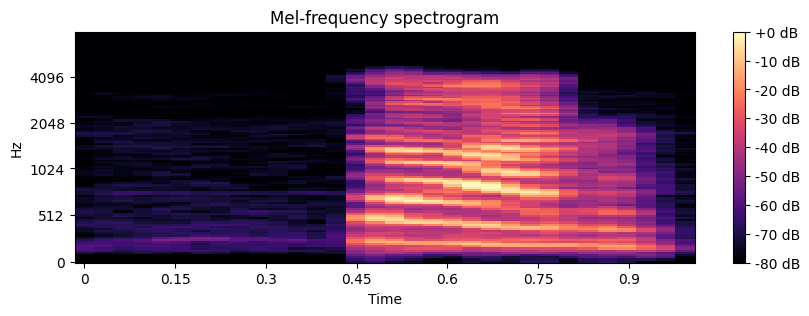

MFCC Coefficients:


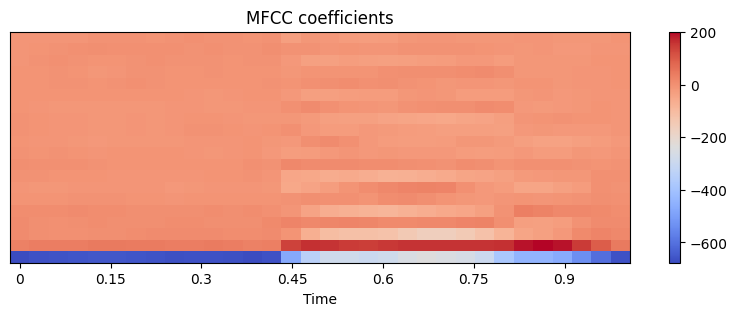

Chromagram:


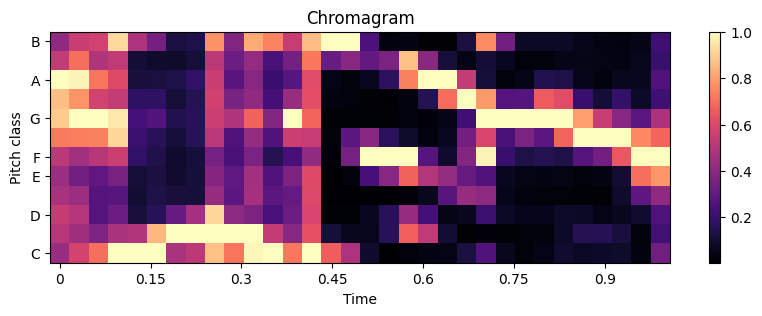


=== BIRD ===
File: ab76ac76_nohash_1.wav
Mel Spectrogram:


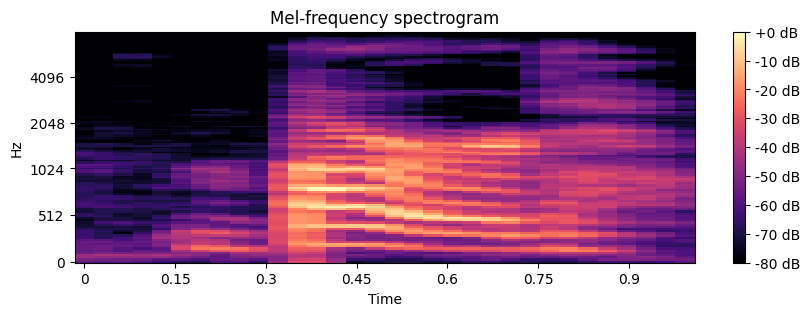

MFCC Coefficients:


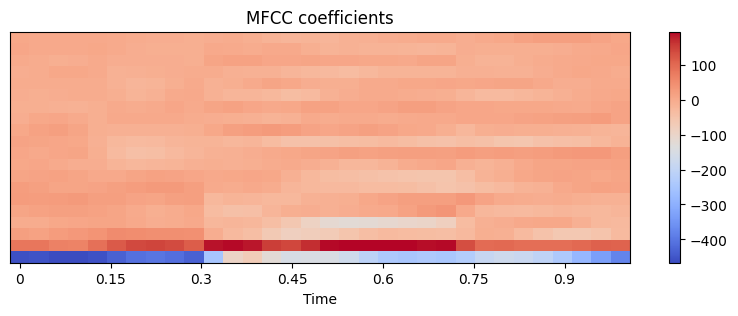

Chromagram:


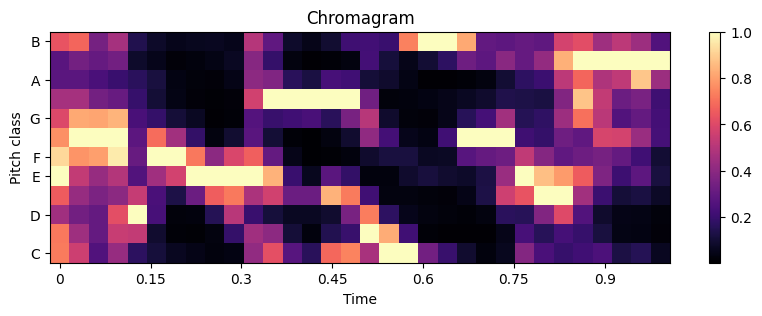


=== CAT ===
File: b93528e3_nohash_0.wav
Mel Spectrogram:


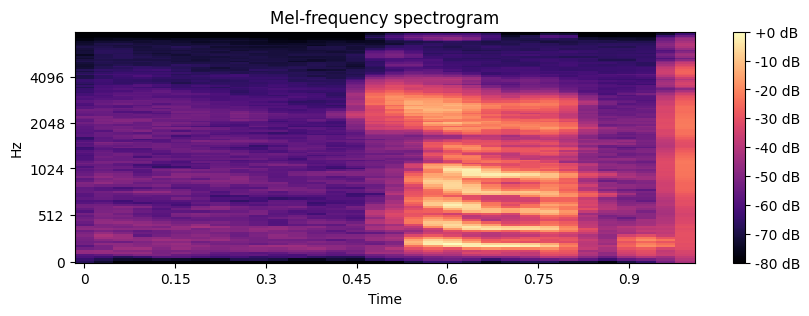

MFCC Coefficients:


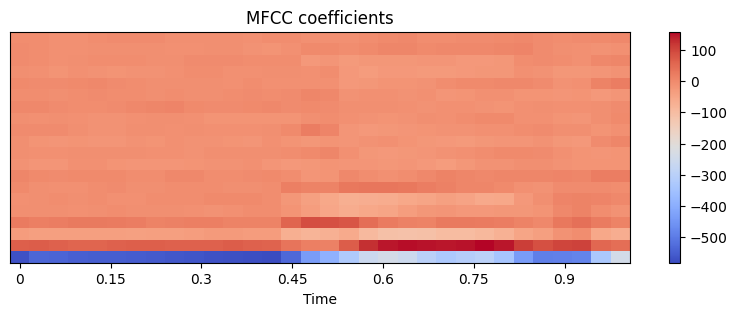

Chromagram:


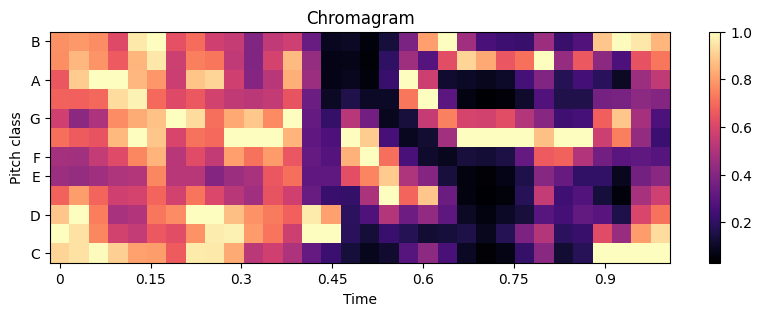

In [10]:
# Step 3: Visualize Audio Features using our existing functions

# Pick one sample from each animal class
sample_files = []
for label in df['label'].unique():
    sample_file = df[df['label'] == label]['file_path'].iloc[0]
    sample_files.append((sample_file, label))

# Visualize features for each sample using our compact functions
for file_path, label in sample_files:
    print(f"\n=== {label.upper()} ===")
    print(f"File: {os.path.basename(file_path)}")

    # Load audio
    audio, sr = librosa.load(file_path, sr=16000)

    # Extract features
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    # Use our pre-defined functions
    print("Mel Spectrogram:")
    plot_mel(mel_db, sr)

    print("MFCC Coefficients:")
    plot_mfcc(mfcc, sr)

    print("Chromagram:")
    plot_chroma(chroma, sr)

## Step 4: Prepare Data for CNN

Extract features for all files and prepare train/test sets:

In [11]:
from tqdm import tqdm  # Import tqdm


In [12]:
# def prepare_dataset(df, feature_type='mfcc', time_steps=100):
#     X = []
#     y = []

#     for row in tqdm(df.itertuples(), total=len(df), desc="Processing audio files"):
#         file_path = row.file_path
#         label = row.label

#         try:
#             # USE OUR EXISTING EXTRACTION FUNCTIONS
#             if feature_type == 'mfcc':
#                 feature = extract_mfcc(file_path, max_len=time_steps)
#             elif feature_type == 'mel':
#                 feature = extract_mel_spectrogram(file_path, max_len=time_steps)
#             elif feature_type == 'chroma':
#                 feature = extract_chromagram(file_path, max_len=time_steps)

#             if feature is not None:
#                 # Normalize (like your preferred style)
#                 feature_norm = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))

#                 # Add channel dimension for CNN
#                 feature_with_channel = feature_norm.reshape(feature_norm.shape[0], feature_norm.shape[1], 1)

#                 X.append(feature_with_channel)
#                 y.append(label)

#         except Exception as e:
#             print(f"Error processing {file_path}: {e}")
#             continue

#     return np.array(X), np.array(y)

In [13]:
def prepare_dataset(df, feature_type='mfcc', fixed_size=100):
    X = []
    y = []

    # Add tqdm wrapper around the loop to display the progress bar
    for row in tqdm(df.itertuples(), total=len(df), desc="Processing audio files"):
        file_path = row.file_path
        label = row.label

        # Extract features based on chosen type
        if feature_type == 'mfcc':
            feature = extract_mfcc(file_path, max_len=fixed_size)
        elif feature_type == 'mel':
            feature = extract_mel_spectrogram(file_path, max_len=fixed_size)
        elif feature_type == 'chroma':
            feature = extract_chromagram(file_path, max_len=fixed_size)
        else:
            feature = extract_mfcc(file_path, max_len=fixed_size)  # default

        # # Normalize the feature
        # feature_norm = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))

        # # Resize to fixed size
        # feature_resized = librosa.util.fix_length(feature_norm, size=fixed_size, axis=1)
        # feature_resized = librosa.util.fix_length(feature_resized, size=feature.shape[0], axis=0)

        # Normalize
        feature_norm = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))

        # Only fix the TIME dimension
        feature_fixed = librosa.util.fix_length(feature_norm, size=fixed_size, axis=1)

        # ADD CHANNEL DIMENSION (important!)
        feature_with_channel = feature_fixed.reshape(feature_fixed.shape[0], feature_fixed.shape[1], 1)

        X.append(feature_with_channel)
        y.append(label)

    return np.array(X), np.array(y)

In [14]:
# Convert labels to numbers
def encode_labels(labels):
    """Convert string labels to numerical values"""
    label_map = {'cat': 0, 'dog': 1, 'bird': 2}
    numerical_labels = [label_map[label] for label in labels]
    return to_categorical(numerical_labels)  # Convert to one-hot encoding

In [15]:
# Step 1: Prepare data
X, y = prepare_dataset(df, feature_type='mfcc', fixed_size=100)
print(f"\nX shape: {X.shape}")  # Should be (num_samples, 13, 100, 1)
print(f"y length: {len(y)}")

Processing audio files: 100%|██████████| 610/610 [00:03<00:00, 155.53it/s]


X shape: (610, 13, 100, 1)
y length: 610


In [16]:
# # Simple one-liner to prepare data
# X, y = prepare_dataset(df, feature_type='mfcc', fixed_size=100)

# print(f"X shape: {X.shape}")
# print(f"y length: {len(y)}")


In [17]:
# Encode labels and split
y_encoded = encode_labels(y)


# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nFinal dataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Show class distribution
train_classes = np.argmax(y_train, axis=1)
test_classes = np.argmax(y_test, axis=1)

print(f"\nTraining set - Cats: {np.sum(train_classes == 0)}, Dogs: {np.sum(train_classes == 1)}, Birds: {np.sum(train_classes == 2)}")
print(f"Test set - Cats: {np.sum(test_classes == 0)}, Dogs: {np.sum(test_classes == 1)}, Birds: {np.sum(test_classes == 2)}")


Final dataset shapes:
X_train: (488, 13, 100, 1), y_train: (488, 3)
X_test: (122, 13, 100, 1), y_test: (122, 3)

Training set - Cats: 166, Dogs: 168, Birds: 154
Test set - Cats: 41, Dogs: 42, Birds: 39


## Step 5: Define CNN Model

In [18]:
# Step 4: Create and train model
def create_cnn_model(input_shape, num_classes=3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create model
input_shape = X_train[0].shape  # (13, 100, 1)
model = create_cnn_model(input_shape, num_classes=3)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 49, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 47, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       188,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,747 (811.51 KB)

 Trainable params: 207,747 (811.51 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train and Evaluate

In [20]:
##TODO: Your_Code_Here

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6409 - loss: 0.8226 - val_accuracy: 0.7295 - val_loss: 0.7178
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7225 - loss: 0.6986 - val_accuracy: 0.7623 - val_loss: 0.6713
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7156 - loss: 0.7145 - val_accuracy: 0.7131 - val_loss: 0.6584
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6967 - loss: 0.6885 - val_accuracy: 0.6475 - val_loss: 0.6763
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6825 - loss: 0.6632 - val_accuracy: 0.8361 - val_loss: 0.6173
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7625 - loss: 0.6190 - val_accuracy: 0.8197 - val_loss: 0.5881
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7785 - loss: 0.6017 - val_accuracy: 0.8115 - val_loss: 0.5894
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7477 - loss: 0.6080 - val_accuracy: 0.


Evaluating on test set...
Test Accuracy: 0.9262
Test Loss: 0.2056


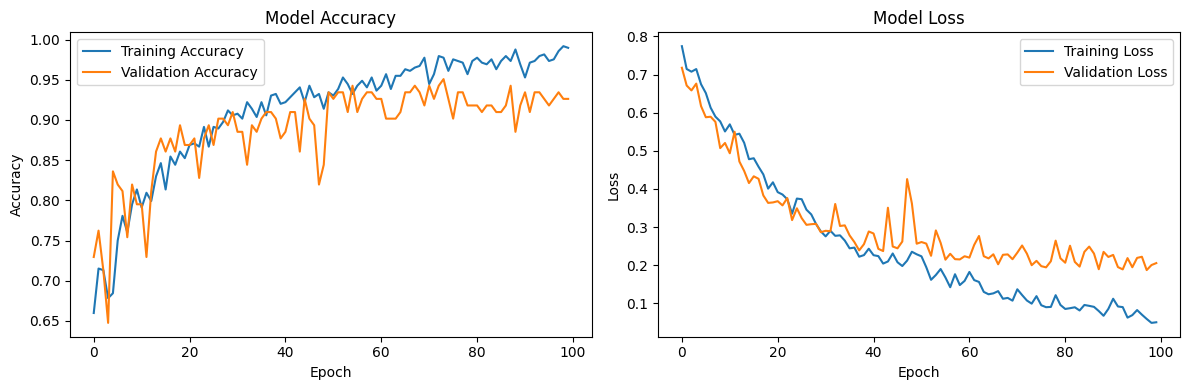

In [21]:
# Evaluate the model on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [22]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['cat', 'dog', 'bird']
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Classification Report:
              precision    recall  f1-score   support

         cat       0.93      0.90      0.91        41
         dog       0.91      1.00      0.95        42
        bird       0.94      0.87      0.91        39

    accuracy                           0.93       122
   macro avg       0.93      0.92      0.92       122
weighted avg       0.93      0.93      0.93       122

Confusion Matrix:
[[37  2  2]
 [ 0 42  0]
 [ 3  2 34]]


## Step 7: Experimentation

- Try using Mel Spectrogram and Chromagram as features instead of MFCC by changing the `feature_extractor` function in the data preparation.
- Modify parameters like `n_mfcc`, `n_mels`, `max_len`.
- Tune CNN architecture (add layers, change filters).
- Compare results and report observations.


In [24]:
# Step 7: Experimentation
print("\n" + "="*60)
print("STEP 7: EXPERIMENTATION")
print("="*60)

def run_experiment(feature_type='mfcc', fixed_size=100, epochs=15, model_name="Basic CNN"):
    """
    Run a complete experiment with given parameters
    """
    print(f"\n🔬 Experiment: {model_name}")
    print(f"Feature type: {feature_type}, Size: {fixed_size}")

    # Prepare data
    X, y = prepare_dataset(df, feature_type=feature_type, fixed_size=fixed_size)
    y_encoded = encode_labels(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print(f"Data shape: {X_train.shape}")

    # Create model
    input_shape = X_train[0].shape
    model = create_cnn_model(input_shape, num_classes=3)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )

    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ {model_name} - Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy, history



STEP 7: EXPERIMENTATION


In [25]:
# Experiment 1: Compare different feature types
print("\n1. COMPARING FEATURE TYPES")
feature_results = {}

for feature_type in ['mfcc', 'mel', 'chroma']:
    accuracy, history = run_experiment(
        feature_type=feature_type,
        fixed_size=100,
        epochs=15,
        model_name=f"{feature_type.upper()} Features"
    )
    feature_results[feature_type] = accuracy


1. COMPARING FEATURE TYPES

🔬 Experiment: MFCC Features
Feature type: mfcc, Size: 100


Processing audio files: 100%|██████████| 610/610 [00:04<00:00, 135.14it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Data shape: (488, 13, 100, 1)
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3455 - loss: 1.1056 - val_accuracy: 0.3443 - val_loss: 1.0969
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3612 - loss: 1.0970 - val_accuracy: 0.3443 - val_loss: 1.0965
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3956 - loss: 1.0936 - val_accuracy: 0.3525 - val_loss: 1.0968
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3583 - loss: 1.0968 - val_accuracy: 0.3525 - val_loss: 1.0960
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3627 - loss: 1.0943 - val_accuracy: 0.3525 - val_loss: 1.0957
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3725 - loss: 1.0906 - val_accuracy: 0.3525 - val_loss: 1.0950
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4128 - loss: 1.0863 - val_accuracy: 0.3525 - val_loss: 1.0935
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3657 - loss: 1.0

Processing audio files: 100%|██████████| 610/610 [00:03<00:00, 181.39it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Data shape: (488, 128, 100, 1)
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.3770 - loss: 1.1304 - val_accuracy: 0.5246 - val_loss: 1.0588
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.4773 - loss: 1.0422 - val_accuracy: 0.5164 - val_loss: 0.9594
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5704 - loss: 0.9358 - val_accuracy: 0.7049 - val_loss: 0.7067
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.6252 - loss: 0.7941 - val_accuracy: 0.7623 - val_loss: 0.6562
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.7125 - loss: 0.6640 - val_accuracy: 0.7377 - val_loss: 0.5513
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.7776 - loss: 0.5794 - val_accuracy: 0.8115 - val_loss: 0.4467
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.8078 - loss: 0.4559 - val_accuracy: 0.8033 - val_loss: 0.4233
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.862

Processing audio files:  17%|█▋        | 102/610 [00:00<00:03, 148.73it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing audio files: 100%|██████████| 610/610 [00:03<00:00, 154.55it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Data shape: (488, 12, 100, 1)
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3145 - loss: 1.1053 - val_accuracy: 0.3770 - val_loss: 1.0907
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3920 - loss: 1.0791 - val_accuracy: 0.4672 - val_loss: 1.0779
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4575 - loss: 1.0557 - val_accuracy: 0.4754 - val_loss: 1.0521
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5304 - loss: 1.0178 - val_accuracy: 0.4508 - val_loss: 1.0414
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5338 - loss: 0.9456 - val_accuracy: 0.4426 - val_loss: 1.0418
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5703 - loss: 0.9286 - val_accuracy: 0.4836 - val_loss: 1.0361
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5800 - loss: 0.8850 - val_accuracy: 0.4508 - val_loss: 1.0251
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5921 - loss: 0.9

In [26]:
# Experiment 2: Try different input sizes
print("\n2. COMPARING DIFFERENT INPUT SIZES")
size_results = {}

for size in [50, 100, 150]:
    accuracy, history = run_experiment(
        feature_type='mfcc',  # Use the best feature from previous experiment
        fixed_size=size,
        epochs=15,
        model_name=f"MFCC with size {size}"
    )
    size_results[size] = accuracy


2. COMPARING DIFFERENT INPUT SIZES

🔬 Experiment: MFCC with size 50
Feature type: mfcc, Size: 50


Processing audio files: 100%|██████████| 610/610 [00:03<00:00, 185.61it/s]

Data shape: (488, 13, 50, 1)
Epoch 1/15



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3548 - loss: 1.1106 - val_accuracy: 0.3361 - val_loss: 1.0971
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4061 - loss: 1.0917 - val_accuracy: 0.3443 - val_loss: 1.0972
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3425 - loss: 1.0954 - val_accuracy: 0.3443 - val_loss: 1.0972
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3592 - loss: 1.0956 - val_accuracy: 0.3361 - val_loss: 1.0961
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3408 - loss: 1.1004 - val_accuracy: 0.3361 - val_loss: 1.0957
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3820 - loss: 1.0918 - val_accuracy: 0.3525 - val_loss: 1.0955
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3494 - loss: 1.0934 - val_accuracy: 0.3525 - val_loss: 1.0931
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3688 - loss: 1.0904 - val_accuracy: 0.3607 - val_loss: 1.

Processing audio files: 100%|██████████| 610/610 [00:04<00:00, 140.04it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Data shape: (488, 13, 100, 1)
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3472 - loss: 1.1039 - val_accuracy: 0.3443 - val_loss: 1.0960
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3622 - loss: 1.0976 - val_accuracy: 0.3443 - val_loss: 1.0955
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3151 - loss: 1.1065 - val_accuracy: 0.3443 - val_loss: 1.0969
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3604 - loss: 1.0984 - val_accuracy: 0.3443 - val_loss: 1.0971
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3956 - loss: 1.0949 - val_accuracy: 0.3443 - val_loss: 1.0962
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3301 - loss: 1.0947 - val_accuracy: 0.3525 - val_loss: 1.0949
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3767 - loss: 1.0945 - val_accuracy: 0.3443 - val_loss: 1.0939
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3459 - loss: 1.0

Processing audio files: 100%|██████████| 610/610 [00:04<00:00, 145.72it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Data shape: (488, 13, 150, 1)
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3024 - loss: 1.1039 - val_accuracy: 0.3361 - val_loss: 1.0965
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3459 - loss: 1.0986 - val_accuracy: 0.3443 - val_loss: 1.0969
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3038 - loss: 1.0995 - val_accuracy: 0.4426 - val_loss: 1.0952
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3713 - loss: 1.0929 - val_accuracy: 0.3525 - val_loss: 1.0941
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3497 - loss: 1.0941 - val_accuracy: 0.4836 - val_loss: 1.0937
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4192 - loss: 1.0928 - val_accuracy: 0.4508 - val_loss: 1.0900
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3726 - loss: 1.0910 - val_accuracy: 0.4098 - val_loss: 1.0861
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3382 - loss: 1.0

In [27]:
# Experiment 3: Try different CNN architectures
print("\n3. COMPARING CNN ARCHITECTURES")

def create_deeper_cnn(input_shape, num_classes=3):
    """Deeper CNN architecture"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_wider_cnn(input_shape, num_classes=3):
    """Wider CNN architecture"""
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Test different architectures
X, y = prepare_dataset(df, feature_type='mfcc', fixed_size=100)
y_encoded = encode_labels(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
input_shape = X_train[0].shape

architectures = {
    'Basic CNN': create_cnn_model,
    'Deeper CNN': create_deeper_cnn,
    'Wider CNN': create_wider_cnn
}

architecture_results = {}

for arch_name, arch_func in architectures.items():
    print(f"\nTesting {arch_name}...")
    model = arch_func(input_shape, num_classes=3)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ {arch_name} - Test Accuracy: {test_accuracy:.4f}")
    architecture_results[arch_name] = test_accuracy



3. COMPARING CNN ARCHITECTURES


Processing audio files: 100%|██████████| 610/610 [00:03<00:00, 182.07it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Testing Basic CNN...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2903 - loss: 1.1118 - val_accuracy: 0.3361 - val_loss: 1.0969
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3502 - loss: 1.0969 - val_accuracy: 0.3525 - val_loss: 1.0956
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3721 - loss: 1.0927 - val_accuracy: 0.3852 - val_loss: 1.0955
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3352 - loss: 1.0959 - val_accuracy: 0.3525 - val_loss: 1.0949
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3563 - loss: 1.0909 - val_accuracy: 0.3525 - val_loss: 1.0937
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3351 - loss: 1.0941 - val_accuracy: 0.4016 - val_loss: 1.0931
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3350 - loss: 1.0914 - val_accuracy: 0.3443 - val_loss: 1.0948
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3867 - loss: 1.0904 - va

ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 23, 64)`, `kernel shape=(3, 3, 64, 128)`, `dilation_rate=[1 1]`.

In [28]:

# Summary of all experiments
print("\n" + "="*60)
print("EXPERIMENT RESULTS SUMMARY")
print("="*60)

print("\n📊 Feature Type Results:")
for feature, accuracy in feature_results.items():
    print(f"  {feature.upper()}: {accuracy:.4f}")

print("\n📊 Input Size Results:")
for size, accuracy in size_results.items():
    print(f"  Size {size}: {accuracy:.4f}")

print("\n📊 Architecture Results:")
for arch, accuracy in architecture_results.items():
    print(f"  {arch}: {accuracy:.4f}")

# Find best configuration
best_feature = max(feature_results, key=feature_results.get)
best_size = max(size_results, key=size_results.get)
best_arch = max(architecture_results, key=architecture_results.get)

print(f"\n🏆 BEST CONFIGURATION:")
print(f"  Feature: {best_feature.upper()} ({feature_results[best_feature]:.4f})")
print(f"  Size: {best_size} ({size_results[best_size]:.4f})")
print(f"  Architecture: {best_arch} ({architecture_results[best_arch]:.4f})")

print("\n💡 Observations:")
print("• Which feature type captured animal sounds best?")
print("• Did longer audio sequences (larger size) help?")
print("• Which CNN architecture balanced speed and accuracy?")
print("• Any signs of overfitting in the training curves?")


EXPERIMENT RESULTS SUMMARY

📊 Feature Type Results:
  MFCC: 0.5000
  MEL: 0.9262
  CHROMA: 0.5984

📊 Input Size Results:
  Size 50: 0.4754
  Size 100: 0.5246
  Size 150: 0.5410

📊 Architecture Results:
  Basic CNN: 0.4508

🏆 BEST CONFIGURATION:
  Feature: MEL (0.9262)
  Size: 150 (0.5410)
  Architecture: Basic CNN (0.4508)

💡 Observations:
• Which feature type captured animal sounds best?
• Did longer audio sequences (larger size) help?
• Which CNN architecture balanced speed and accuracy?
• Any signs of overfitting in the training curves?
